# **Estimation et visualisation du flux optique**

Ce notebook montre l'exécution de quelques approches classiques du flux optique:
- Dense optical flow (Gunnar Farneback)
- Sparse optical flow (Pyramidal Lucas–Kanade)
- RLOF

Pour ce faire, on va suivre [ce tutoriel](https://learnopencv.com/optical-flow-in-opencv/).

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def show(img, title=None, figsize=(8,6)):
  if len(img.shape)==2:
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if title:
      plt.title(title)
  plt.show()

In [2]:
def load_frames_from_video(path, max_frames=60, resize=None):
  cap = cv2.VideoCapture(path)
  frames = []
  i = 0
  while cap.isOpened() and i < max_frames:
    ret, frame = cap.read()
    if not ret:
      break
    if resize is not None:
      frame = cv2.resize(frame, resize)
    frames.append(frame)
    i += 1
  cap.release()
  return frames

## Méthode dense : Farneback
Cette méthode fonctionne en approximant les fenêtres d'image avec des polynômes quadratiques, puis en estimant le champ de déplacement basé sur ces transformations.

In [19]:
def dense_farneback(prev_gray, gray):
  flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  return flow

def flow_to_hsv(flow):
  h, w = flow.shape[:2]
  mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  hsv = np.zeros((h,w,3), dtype=np.uint8)
  hsv[...,0] = ang * 180 / np.pi / 2
  hsv[...,1] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
  hsv[...,2] = 255
  rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
  return rgb

### Méthode sparse : Lucas–Kanade
L'idée principale de cette méthode repose sur l'hypothèse de constance du mouvement local, où les pixels voisins ont la même direction de déplacement. Cette hypothèse permet d'obtenir une solution approximative de l'équation à deux variables.

In [20]:
def sparse_lk(prev_gray, gray, prev_pts):
  lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
  p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_pts, None, **lk_params)
  if p1 is None:
    return None, None
  good_new = p1[st==1]
  good_old = prev_pts[st==1]
  return good_old, good_new


def draw_tracks(frame, old, new, max_draw=200):
  out = frame.copy()
  for (a,b) in zip(old[:max_draw], new[:max_draw]):
    x1,y1 = a.ravel(); x2,y2 = b.ravel()
    cv2.circle(out, (int(x2),int(y2)), 3, (0,255,0), -1)
    cv2.line(out, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 1)
  return out

### Méthode RLOF
L'algorithme RLOF, contrairement à Farneback, nécessite une image à 3 canaux, il n'y a donc pas de prétraitement ici.

In [24]:
def dense_rlof(prev_gray, gray):
  # default params
  flow = cv2.optflow.calcOpticalFlowDenseRLOF(prev_gray, gray, None)
  return flow

Loaded 120 frames


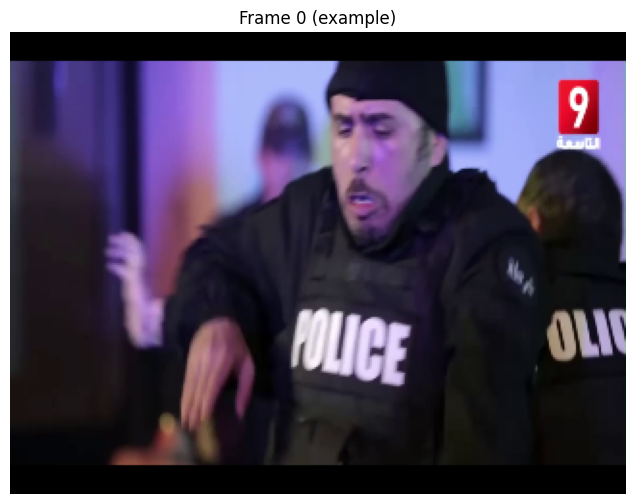

In [17]:
video_path = '/content/my_video.mp4'
frames = load_frames_from_video(video_path, max_frames=120, resize=(320,240))
print('Loaded', len(frames), 'frames')
show(frames[0], title='Frame 0 (example)')

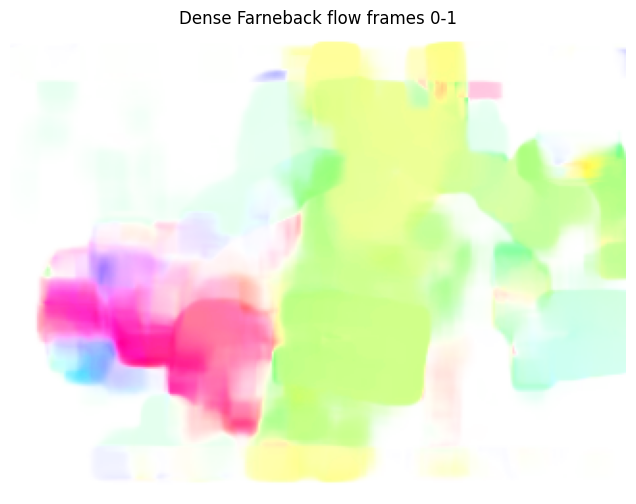

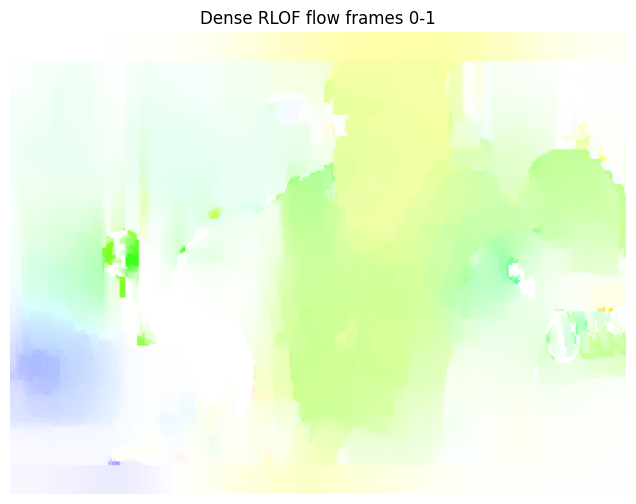

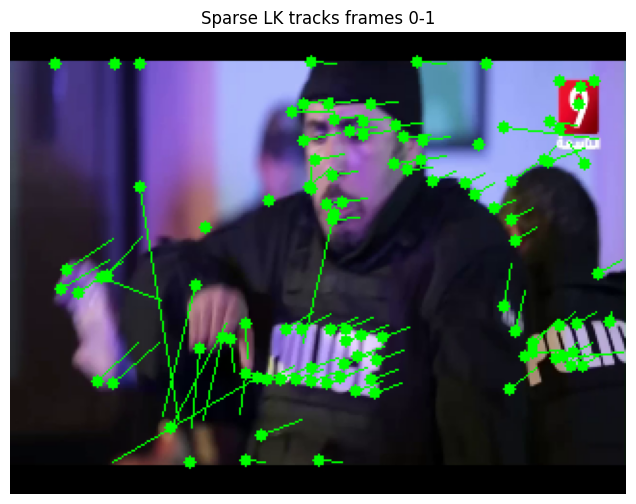

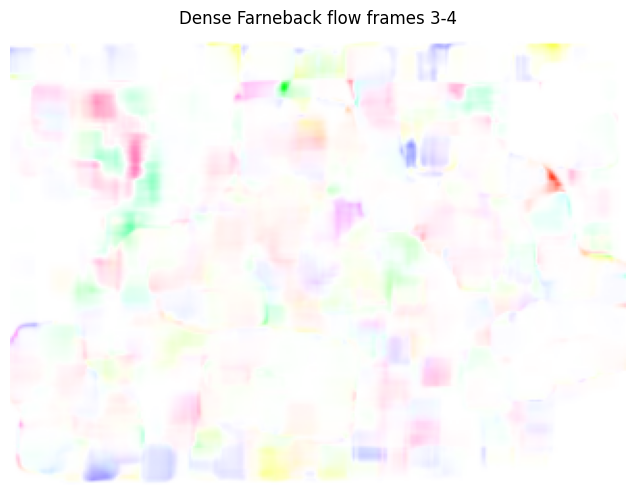

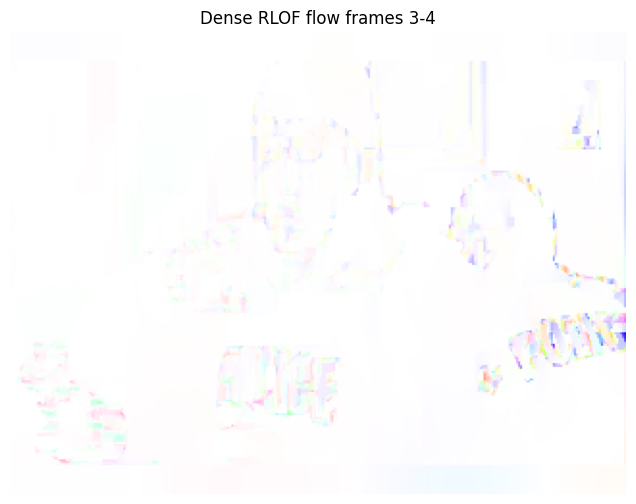

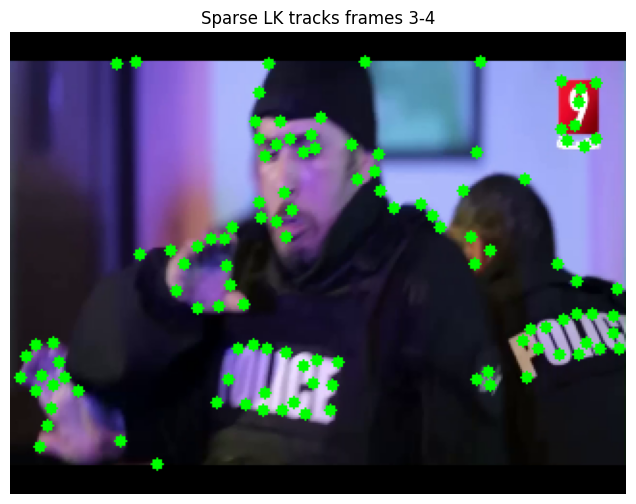

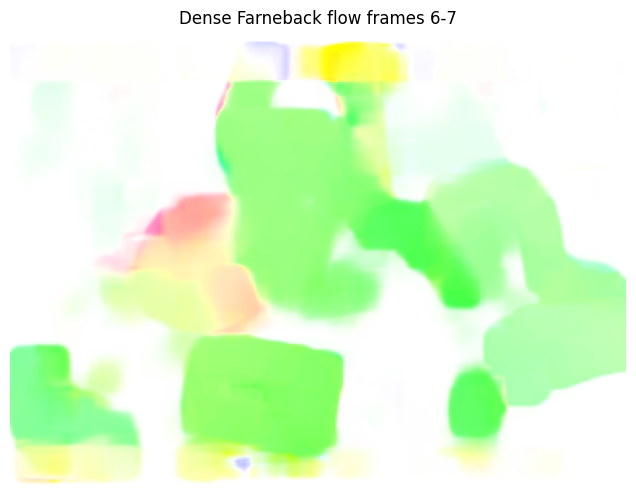

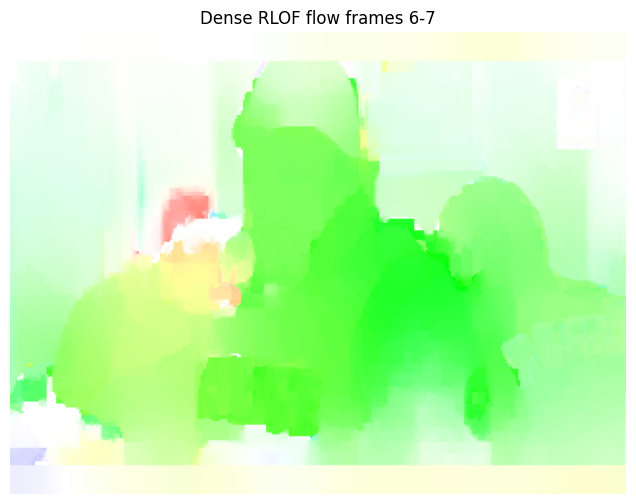

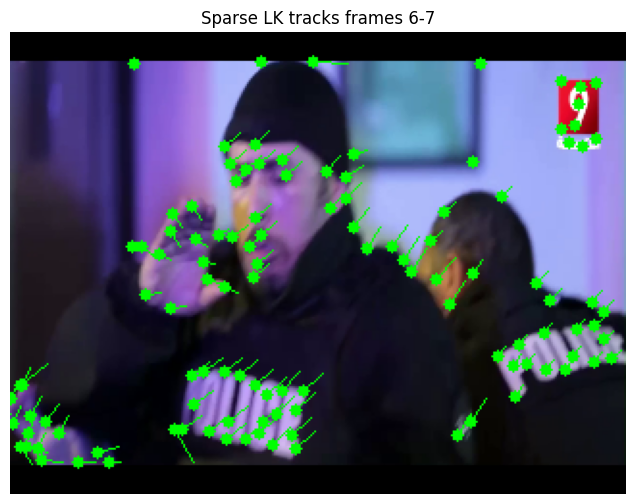

In [27]:
num_examples = 3
step = 3
for start in range(0, 8, step):
  f1, f2, f3 = frames[start:start+3]
  g1 = cv2.cvtColor(f1, cv2.COLOR_BGR2GRAY)
  g2 = cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY)
  g3 = cv2.cvtColor(f3, cv2.COLOR_BGR2GRAY)


  # DENSE : Farneback et RLOF
  flow_fb = dense_farneback(g1, g2)
  flow_rlof = dense_rlof(f1, f2) # Pass color frames to dense_rlof
  vis_fb = flow_to_hsv(flow_fb)
  vis_rlof = flow_to_hsv(flow_rlof)


  show(vis_fb, title=f'Dense Farneback flow frames {start}-{start+1}')
  show(vis_rlof, title=f'Dense RLOF flow frames {start}-{start+1}')


  # SPARSE : Lucas–Kanade
  p0 = cv2.goodFeaturesToTrack(g1, mask=None, maxCorners=200, qualityLevel=0.01, minDistance=7)
  if p0 is not None:
    old12, new12 = sparse_lk(g1, g2, p0)
    if old12 is not None:
      vis_sparse12 = draw_tracks(f2, old12, new12)
      show(vis_sparse12, title=f'Sparse LK tracks frames {start}-{start+1}')

Pour comparer visuellement les résultats entre les approches Farneback, Lucas–Kanade et RLOF, on cherche à répondre à cette question: *Quelle méthode produit un flux optique plus cohérent, plus dense, et plus robuste face aux variations d’éclairage et aux grands déplacements ?*

D'après les résultats ci dessus, pour les memes paires de frames (**frames 0-1** et **frames 6-7**), la 1ere méthode (Farneback) donne une estimation continue du flux. Le champ est lisse mais présente du bruit dans les zones sans texture. Les directions de mouvement sont globalement cohérentes.

La 2eme méthode (RLOF) produit un flux plus robuste aux variations locales d’éclairage. Les contours sont nets et le champ moins bruité que Farneback. Elle gère mieux les grands mouvements et les changements de texture, ce qui le rend adapté à des scènes plus complexes comme notre cas.

La dernière méthode (Sparse LK) suit fidèlement les coins contrastés mais ne fournit aucune information sur les surfaces homogènes (tenue bolice). La méthode reste très stable, mais échoue si la texture disparaît.

Pour les **frames 3-4** (scène quasi statique), toute méthode produit un petit flux. Dans notre cas, RLOF tend à produire moins de fausses détections que Farneback ; LK renvoie des vecteurs presque nuls sur coins.